<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Функции-и-библиотеки" data-toc-modified-id="Функции-и-библиотеки-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Функции и библиотеки</a></span></li><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#datetime" data-toc-modified-id="datetime-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>datetime</a></span></li><li><span><a href="#ресемплирование" data-toc-modified-id="ресемплирование-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>ресемплирование</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#подготовка-признаков" data-toc-modified-id="подготовка-признаков-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>подготовка признаков</a></span></li><li><span><a href="#обучение" data-toc-modified-id="обучение-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>обучение</a></span><ul class="toc-item"><li><span><a href="#lin_reg" data-toc-modified-id="lin_reg-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>lin_reg</a></span></li><li><span><a href="#GradientBoostingRegressor" data-toc-modified-id="GradientBoostingRegressor-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>GradientBoostingRegressor</a></span></li><li><span><a href="#catboost" data-toc-modified-id="catboost-5.2.3"><span class="toc-item-num">5.2.3&nbsp;&nbsp;</span>catboost</a></span></li><li><span><a href="#isotonic_regr" data-toc-modified-id="isotonic_regr-5.2.4"><span class="toc-item-num">5.2.4&nbsp;&nbsp;</span>isotonic_regr</a></span></li></ul></li></ul></li><li><span><a href="#Финальное-тестирование" data-toc-modified-id="Финальное-тестирование-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Финальное тестирование</a></span></li><li><span><a href="#Заключение" data-toc-modified-id="Заключение-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Заключение</a></span></li></ul></div>

## Функции и библиотеки

In [206]:
import pandas as pd

import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


from sklearn.metrics import mean_squared_error


from sklearn.ensemble import GradientBoostingRegressor

from catboost import CatBoostRegressor

from sklearn.isotonic import IsotonicRegression

from sklearn.linear_model import LinearRegression


import warnings
warnings.filterwarnings('ignore')

In [2]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

## Обзор данных

In [3]:
try:
    df = pd.read_csv ('D:/Data for projects/taxi.csv')

except: 
    df = pd.read_csv ('/datasets/taxi.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


## Предобработка данных

### datetime

In [6]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

In [7]:
df = df.set_index('datetime', drop=True)

In [8]:
df.index.is_monotonic

True

### ресемплирование

In [9]:
df = df.resample('1H').sum()

## Анализ

In [10]:
df['rolling_mean'] = df.rolling(10).mean()

**Количество заказов (дневной график)**

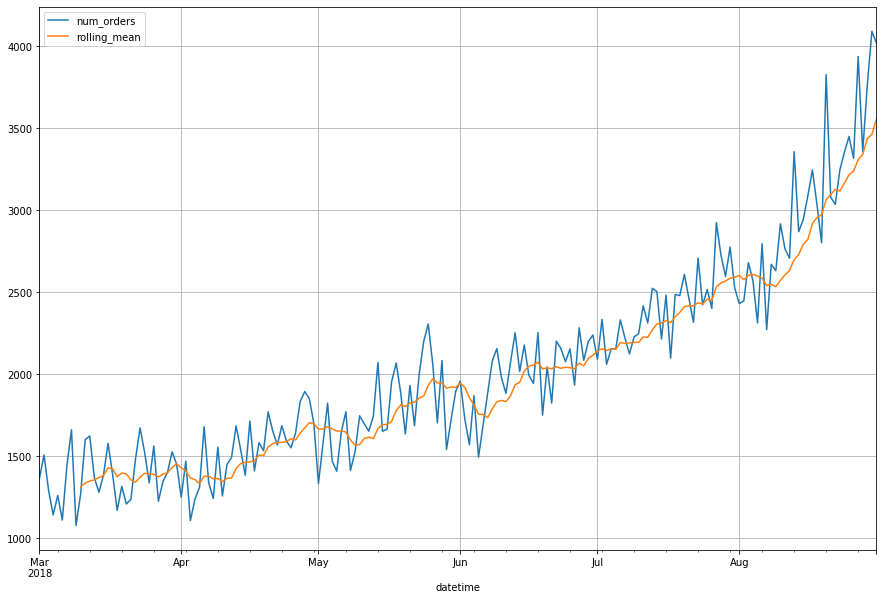

In [104]:
df_by_day = df['num_orders'].resample('1D').sum()

df_by_day = pd.DataFrame(df_by_day)
df_by_day['num_orders'] = df_by_day['num_orders'].astype(int)

df_by_day['rolling_mean'] = df_by_day['num_orders'].rolling(10).mean()


df_by_day.plot(figsize=(15, 10), grid=True)

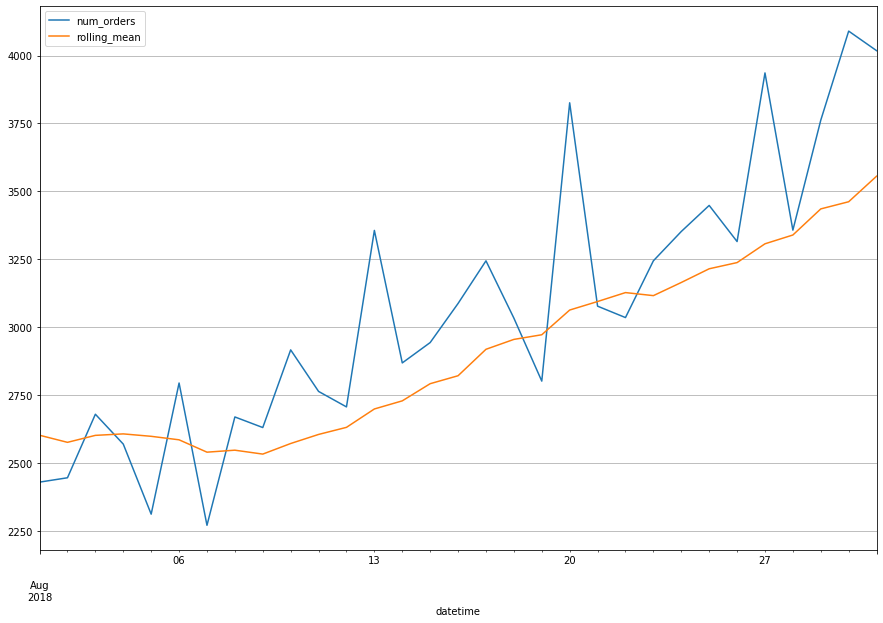

In [105]:
df_by_day['2018-08-01':].plot(figsize=(15, 10), grid=True)

<div style="border:solid blue 2px; padding: 20px">

на графике виден тренд, начинающийся 8-9 августа, что должно негативно сказаться на качестве ряда моделей (например линейной регрессии), т.к. большая часть тренда будет отнесена к тестовой выборке, а начало тренда к валидационной, в итоге модель будет обучаться на данных не учитывающих данный тренд (при этом показав хорошие результаты при обучении)
    
не монотонное возрастание не позволит эффективно использовать изотоническую регрессию
    
в случае не достижения требуемых значений метрики RMSE можно использовать для обучения/тестирования моделей только данные за последний месяц

**Тренды и сезонность на общей выборке**

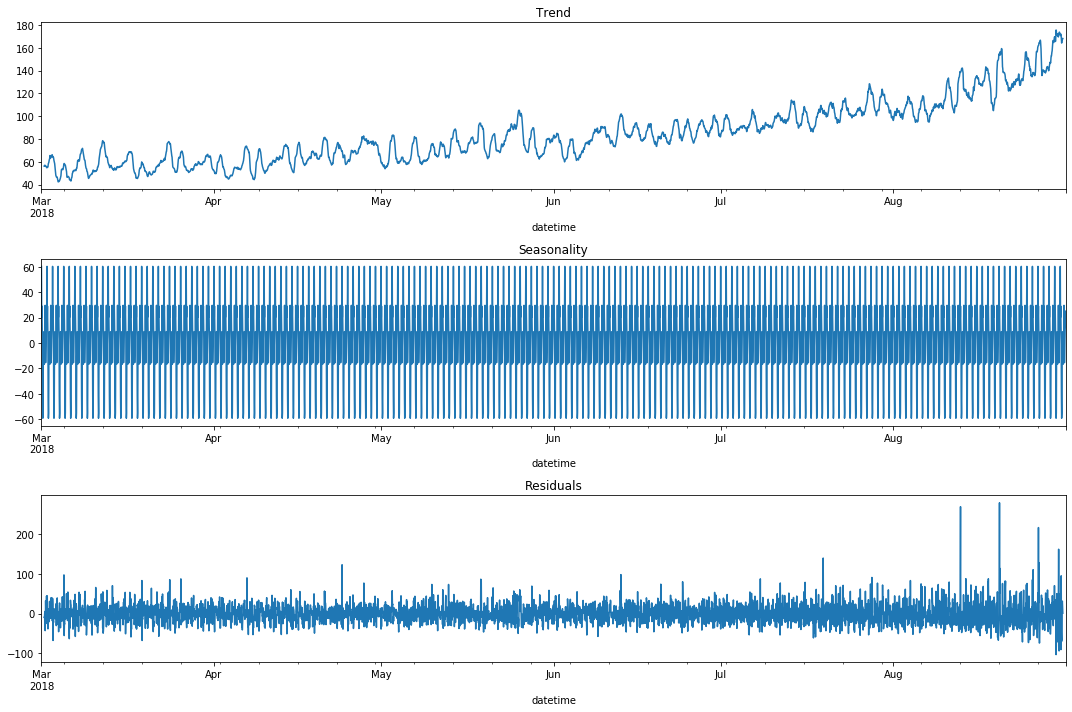

In [12]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(15, 10))
plt.subplot(311)


decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

**Тренды и сезонность в первый месяц**

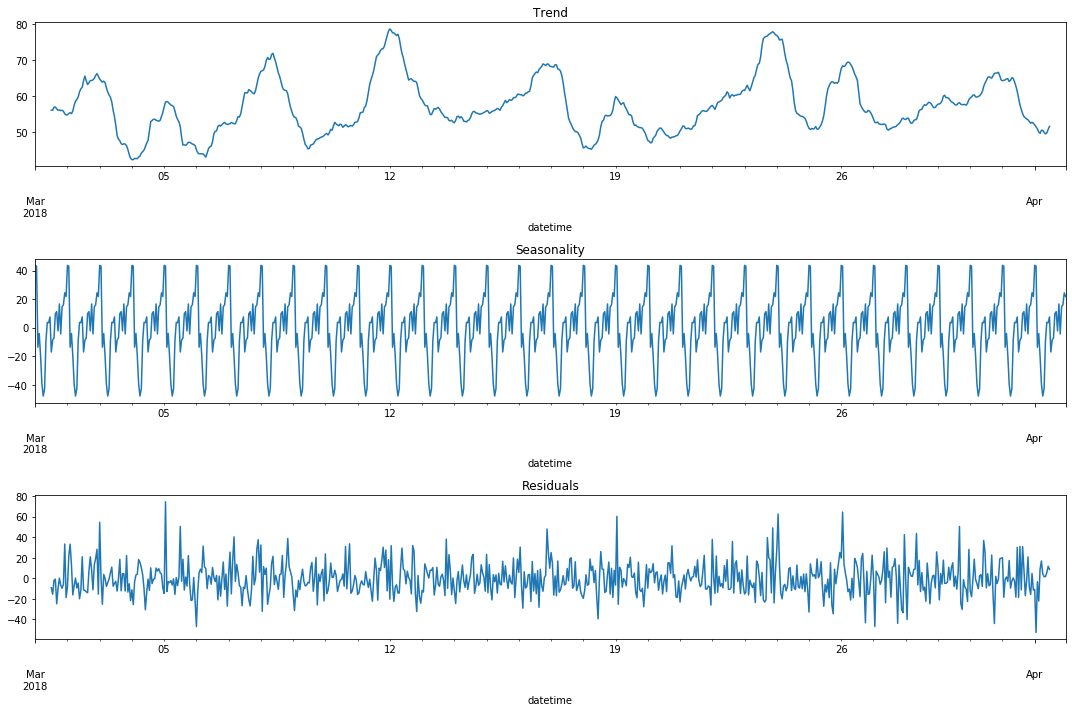

In [13]:
decomposed = seasonal_decompose(df['2018-03-01':'2018-04-01']['num_orders'])

plt.figure(figsize=(15, 10))
plt.subplot(311)


decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

**Тренды и сезонность в последний месяц**

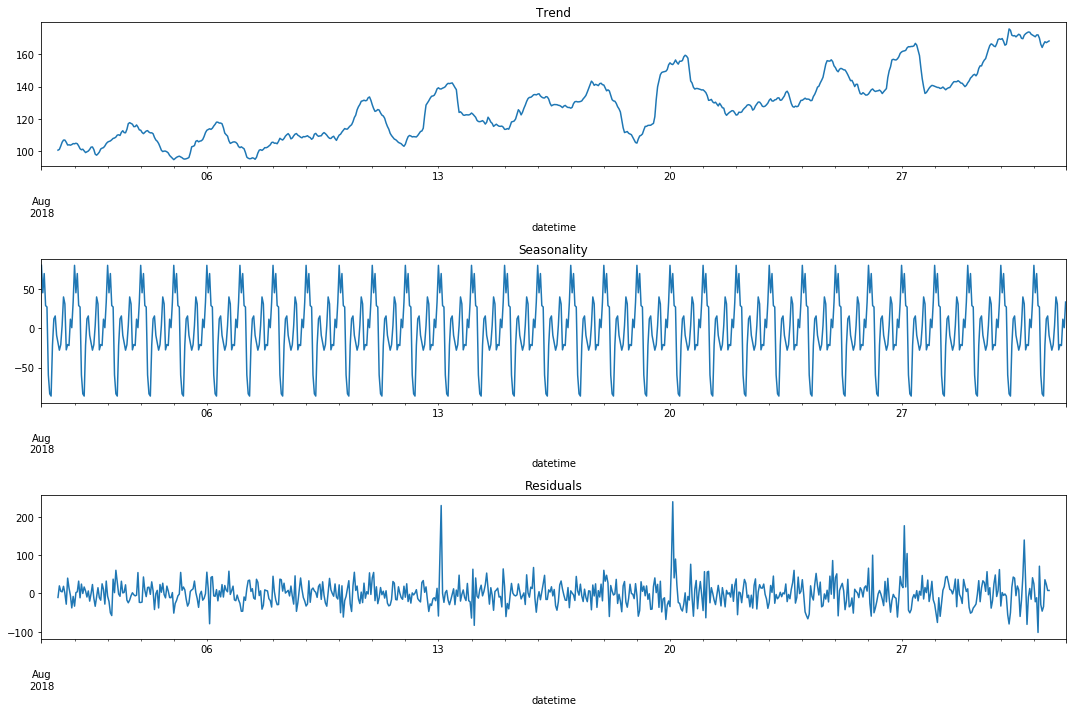

In [14]:
decomposed = seasonal_decompose(df['2018-08-01':'2018-08-31']['num_orders'])

plt.figure(figsize=(15, 10))
plt.subplot(311)


decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

## Обучение моделей

### подготовка признаков

In [188]:
make_features(df, 24, 7)

train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

train, valid = train_test_split(train, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders',axis=1)
target_train = train['num_orders']

features_valid = valid.drop('num_orders',axis=1)
target_valid = valid['num_orders']

features_test = test.drop('num_orders',axis=1)
target_test = test['num_orders']

In [189]:
print (features_train.shape, 
       target_train.shape, 
       features_valid.shape, 
       target_valid.shape, 
       features_test.shape, 
       target_test.shape)

(3536, 49) (3536,) (393, 49) (393,) (442, 49) (442,)


### обучение

#### lin_reg

In [190]:
model_lin_reg = LinearRegression()
model_lin_reg.fit(features_train,target_train)
predictions_lin_reg = model_lin_reg.predict(features_valid)

mean_squared_error(target_valid, predictions_lin_reg)**0.5

33.35201218025577

#### GradientBoostingRegressor

In [191]:
model_GBR = GradientBoostingRegressor(
                         learning_rate=0.05006047227122323,
                         max_depth=2, 
                         n_estimators=200, 
                         subsample=0.16625339668571915,
                         random_state=400
                                             ) 
model_GBR.fit(features_train,target_train) # обучение модели

predictions_GBR = model_lin_reg.predict(features_valid)

mean_squared_error(target_valid, predictions_GBR)**0.5

33.35201218025577

#### catboost

In [202]:
model_catboost =  CatBoostRegressor(
                                random_state=40,  
                                max_depth=2,
                                n_estimators=200, 
                                loss_function='RMSE'
                                           ) 
model_catboost.fit(features_train,target_train, verbose=59)
predictions_catboost = model_catboost.predict(features_valid)

mean_squared_error(target_valid, predictions_catboost)**0.5

Learning rate set to 0.184972
0:	learn: 34.0369995	total: 2.13ms	remaining: 424ms
59:	learn: 22.5407838	total: 128ms	remaining: 298ms
118:	learn: 21.1194435	total: 233ms	remaining: 159ms
177:	learn: 20.1255983	total: 322ms	remaining: 39.8ms
199:	learn: 19.8242254	total: 354ms	remaining: 0us


33.637206070989635

#### isotonic_regr

In [193]:
features_train_iso_reg_1 = features_train['lag_1']
features_valid_iso_reg_1 = features_valid['lag_1']
features_test_iso_reg_1 = features_test['lag_1']

In [194]:
model_iso_reg = IsotonicRegression(out_of_bounds='clip', increasing=True)
model_iso_reg.fit(features_train_iso_reg_1, target_train)
predictions_iso_reg = model_iso_reg.predict(features_valid_iso_reg_1)

mean_squared_error(target_valid, predictions_iso_reg)**0.5

44.712525257442515

In [195]:
mean_squared_error(target_test, model_iso_reg.predict(features_test_iso_reg_1))**0.5

64.40076750226659

Лучшие значения метрики RMSE продемонстрировали модели LinearRegression и GradientBoostingRegressor

## Финальное тестирование

In [204]:
mean_squared_error(target_test, model_lin_reg.predict(features_test))**0.5

49.207079157809325

In [197]:
mean_squared_error(target_test, model_GBR.predict(features_test))**0.5

47.60890842687093

## Заключение

В рамках настоящего исследования проведено обучения ряда моделей, наилучшее значение метрики RMSE на тестовой выборке показала модель **GradientBoostingRegressor**, что обусловленно в первую очередью особенностью представленных данных, а именно наличием тренда, практически полностью попадающего в валидационную и тестовую выборки и не учитывающийся при обучении моделей